A simple CNN approach

In [36]:
import tensorflow as tf
import numpy as np
from nn_utils import *
import matplotlib.pyplot as plt
import tensorflow.keras as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D

In [37]:
# For GPU use.

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [38]:
# Get dataset
train_input,train_label,test_input,test_label = load_dataset(path="dataset/snake_dataset_v3.hdf5")

print("Images train:", train_input.shape)
print("Labels train:", train_label.shape)
print("Images test:", test_input.shape)
print("Labels test:", test_label.shape)

classes = ["copperhead","cottonmouth","watersnake"]

x_train = train_input/255
x_val = test_input/255


# if we want to use one-hot encoding
# y_train = convert_to_one_hot(train_set_label,3)
# y_dev = convert_to_one_hot(dev_set_label,3)

Images train: (1215, 192, 192, 3)
Labels train: (1215,)
Images test: (134, 192, 192, 3)
Labels test: (134,)


In [39]:
y_train = np.reshape(train_label,(len(train_label),1))
y_val = np.reshape(test_label,(len(test_label),1))

print(y_train.shape)

(1215, 1)


###### Model Changes
1. AvgPooling2D 'valid' instead of MaxPooling 'same'

2. no padding to MaxPoolling2D layer

In [40]:
cnn = Sequential()
cnn.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),activation='relu',padding="same",input_shape=(192, 192, 3)))
cnn.add(MaxPooling2D(pool_size=(8,8),strides=(8,8),padding="valid"))
cnn.add(Conv2D(filters=16,kernel_size=(5,5),activation=tf.nn.relu,strides=(1,1),padding="same"))
cnn.add(AveragePooling2D(pool_size=(4,4),strides=(4,4),padding="valid"))
cnn.add(Flatten())
cnn.add(Dense(32, activation=tf.nn.relu))
cnn.add(Dense(3, activation=tf.nn.softmax))

In [41]:
def conv2d_bn(x, filters, kernel, padding="same", strides=(1,1)):
    x = Conv2D(filters=filters, kernel_size=kernel, strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    x = Activation(tf.nn.relu)(x)
    return x

In [82]:
x_in = Input(shape=(192,192,3))
x1 = conv2d_bn(x_in,32,(3,3))
x2 = MaxPooling2D(pool_size=(8,8),strides=(8,8),padding="valid")(x1)
x3 = conv2d_bn(x2,16,(5,5))
x4 = AveragePooling2D(pool_size=(4,4),strides=(4,4),padding="valid")(x3)
x5 = Flatten()(x4)
x6 = Dense(16,kernel_regularizer=K.regularizers.l2(0.001),activation=tf.nn.relu)(x5)
y = Dense(3, activation=tf.nn.softmax)(x6)


model = Model(inputs=x_in, outputs=y)

In [83]:
adam = K.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy',"mse"])

In [84]:
early_stop = K.callbacks.EarlyStopping(monitor='accuracy',patience=3,mode="max")
callbacks = [early_stop]

In [85]:
history = model.fit(x_train, y_train, epochs=25,batch_size=1,callbacks=callbacks)

Train on 1215 samples
Epoch 1/25
1215/1215 [==============================] - 4s 3ms/sample - loss: 1.0996 - accuracy: 0.4272 - mse: 1.0890
Epoch 2/25
1215/1215 [==============================] - 3s 3ms/sample - loss: 0.9876 - accuracy: 0.4988 - mse: 1.1027
Epoch 3/25
1215/1215 [==============================] - 3s 3ms/sample - loss: 0.9153 - accuracy: 0.5613 - mse: 1.1149
Epoch 4/25
1215/1215 [==============================] - 3s 3ms/sample - loss: 0.8359 - accuracy: 0.6230 - mse: 1.1249
Epoch 5/25
1215/1215 [==============================] - 3s 3ms/sample - loss: 0.7649 - accuracy: 0.6691 - mse: 1.1385
Epoch 6/25
1215/1215 [==============================] - 3s 3ms/sample - loss: 0.7058 - accuracy: 0.6988 - mse: 1.1463
Epoch 7/25
1215/1215 [==============================] - 3s 3ms/sample - loss: 0.6661 - accuracy: 0.7325 - mse: 1.1525
Epoch 8/25
1215/1215 [==============================] - 3s 3ms/sample - loss: 0.6000 - accuracy: 0.7481 - mse: 1.1651
Epoch 9/25
1215/1215 [============

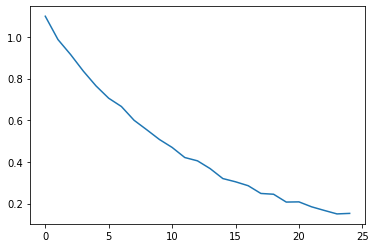

In [86]:
plt.plot(history.history['loss'])

In [87]:
test_loss, test_acc, test_mse = model.evaluate(x_val, y_val)

print('Test accuracy:', test_acc)
print('Test MSE:', test_mse)

134/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

**Max perfomances:**

Test accuracy: 0.73255813

Test MSE: 0.14586309

In [88]:
predictions = model.predict(x_val)

In [89]:
classes = ["copperhead","cottonmouth","watersnake"]

Predicted Classe: copperhead
Confidence: 100.00%
Correct classe: copperhead


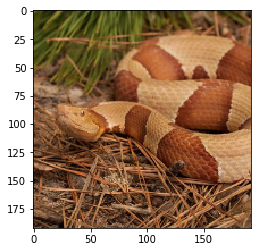

In [94]:
idx = np.random.randint(0,test_input.shape[0])
plt.imshow(test_input[idx])
print("Predicted Classe: {}".format(classes[np.argmax(predictions[idx,:])]))
print("Confidence: {0:.2f}%".format(100*predictions[idx,:].max()))
print("Correct classe: {}".format(classes[int(y_val[idx])]))

In [95]:
import os
from PIL import Image

test_path = "dataset/test_data/"
directory = os.listdir(test_path)
i = 0
images_test = np.empty([len(directory),192,192,3],dtype='uint8')
images_classes = []
for filename in directory:
    img = Image.open(test_path+filename)
    images_classes.append(filename.split('.')[0].split("_")[0])
    img = Image.Image.resize(img,(192,192)).convert("RGB")
    images_test[i] = np.array(img)
    i+=1

ptest = cnn.predict(images_test)

f,axes = plt.subplots(5,4,figsize=(20,20))
for i in range(5):
    for j in range(4):
        image = images_test[i+4*j,:,:,:]
        text = "Predicted: "+classes[np.argmax(ptest[i+4*j,:])] + " True: " + images_classes[i+4*j]
        axes[i][j].set_title(text)
        axes[i][j].imshow(image)
        axes[i][j].axis("off")

ModuleNotFoundError: No module named 'PIL'

In [28]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 16)        12816     
_________________________________________________________________
average_pooling2d (AveragePo (None, 6, 6, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                18464     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

In [86]:
# F1 Weighted metric

from sklearn.metrics import f1_score

y_pred = [np.argmax(predictions[i]) for i in range(predictions.shape[0])]
y_true = [y_val[i,:] for i in range(len(y_val))]

f1_score(y_true=y_true,y_pred=y_pred,labels=[0,1,2],average="weighted")

0.6688179631830983

In [52]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 192, 192, 32)      896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 192, 192, 32)      96        
_________________________________________________________________
activation_7 (Activation)    (None, 192, 192, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 16)        12816     
_________________________________________________________________
batch_normalization_9 (Batch (None, 24, 24, 16)        48  

In [ ]:
tf.n